<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



Выполнил Mahmutov Rinat

Stepik User ID: 97296748

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
import copy
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
DIR = '/content/gdrive/MyDrive/faces_dataset/'

In [ ]:
image_size = 64
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def get_dataloader(image_size, batch_size, stats, DATA_DIR):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  train_ds = ImageFolder(DATA_DIR, 
                         transform=tt.Compose([
                                               tt.Resize(image_size),
                                               tt.CenterCrop(image_size),
                                               tt.ToTensor(),
                                               tt.Normalize(*stats)
                                               ])
                         )
  
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  
  return train_dl

In [ ]:
train_dl = get_dataloader(image_size, batch_size, stats, DIR)

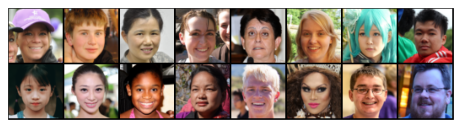

In [ ]:
show_batch(train_dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128 # choose latent size

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

посмотрим на выход генератора

torch.Size([16, 3, 64, 64])


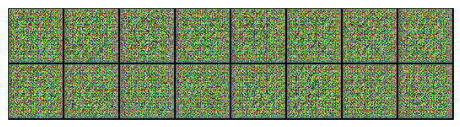

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True, save=True, toColab=False):
    with torch.no_grad():
        fake_images = generator(latent_tensors)
        fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        if save and not toColab:
            save_image(denorm(fake_images)[:6], os.path.join(sample_dir, fake_fname), nrow=6)
            print('Saving', fake_fname)
        elif save and toColab:
            sample_dir = '/content/gdrive/MyDrive/generatedGAN'
            save_image(denorm(fake_images)[:6], os.path.join(sample_dir, fake_fname), nrow=6)
            print('Saving', fake_fname)

        if show:
            fig, ax = plt.subplots(figsize=(21, 5))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(make_grid(denorm(fake_images)[:6].cpu().detach(), nrow=6).permute(1, 2, 0))
            plt.show()

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
# noise coef
alpha = 0.1

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            # Make some noize
            real_targets += alpha * torch.randn_like(real_targets)

            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            # Make some noize
            fake_targets += alpha * torch.abs(torch.randn_like(fake_targets))

            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # каждую 25ю эпоху сохраняем модель
        if (epoch + 1) % 25 == 0:
            model_save = copy.deepcopy(model)
            torch.save(model_save, "/content/gdrive/MyDrive/model_gan.pth")
            score_graph = losses_g + losses_d + real_scores + fake_scores
            torch.save(score_graph, "/content/gdrive/MyDrive/score_graph.pth")

        # Save generated images
        if epoch % 25 == 0:
          save_samples(epoch+start_idx, fixed_latent, show=False, save=True, toColab=True)

        
        clear_output(wait=True)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        
        # промежуточные результаты
        save_samples(epoch+start_idx, fixed_latent, show=True, save=False, toColab=False)

        plt.figure(figsize=(20, 3))
        plt.plot(real_scores, label="real_scores")
        plt.plot(fake_scores, label="fake_scores")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("scores")
        plt.show()  
        
        plt.figure(figsize=(20, 3))
        plt.plot(losses_g, label="losses_generator")
        plt.plot(losses_d, label="losses_discriminator")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()  
    
    return losses_g, losses_d, real_scores, fake_scores    


In [ ]:
epochs = 150
lr = 0.0002

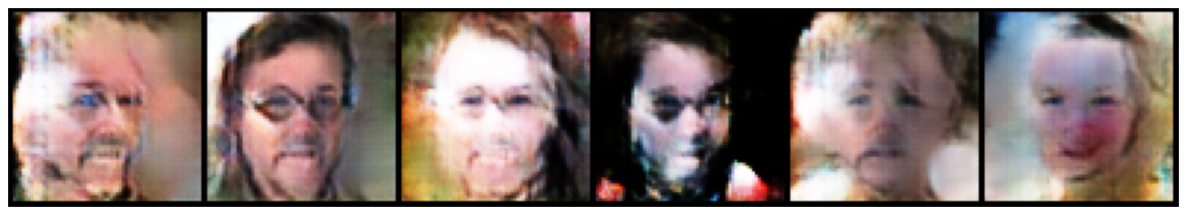

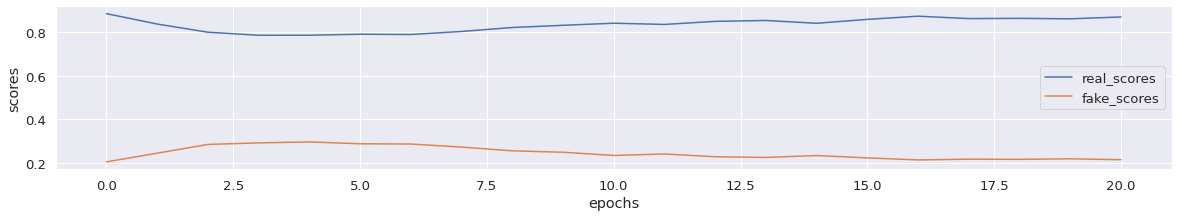

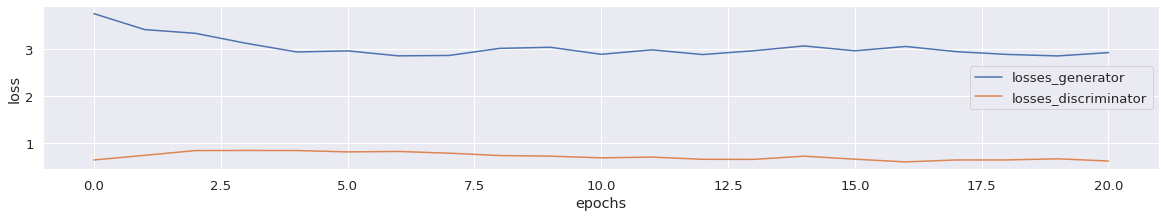

  0%|          | 0/197 [00:00<?, ?it/s]

In [ ]:
history = fit(model, criterion, epochs, lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Дискриминатор побеждает генератор. Хорошо распознает сгенерированные фотографии.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
def show_generated_images(generated):
  fig, ax = plt.subplots(figsize=(21, 10))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(fake_images).cpu().detach(), nrow=10).permute(1, 2, 0))
  plt.show()

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [ ]:
show_generated_images(fake_images)

Как вам качество получившихся изображений?

Качество изображений лучше чем генерирует автоинкодер.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# для увеличения скорости обработки уменьшим размерность реальных картинок и синтезированных до 32х32х3

del train_dl
size = 32
train_ds = ImageFolder(DIR, transform=tt.Compose([tt.Resize(size),tt.ToTensor(),tt.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
# добавим к реальным фото столько же синтезированных и вектор меток 1, 0

n = len(train_dl)
real_pic = [0] * n
fake = [0] * n
for i, real_images in enumerate(train_dl):
      clear_output(wait=True)
      print('Batch', i + 1, 'of', n)
      real_pic[i] = real_images[0].permute(0, 2, 3, 1)
      latent = torch.randn(batch_size,latent_size, 1, 1, device=device)
      fake_gen = model["generator"](latent).cpu().detach()
      fake[i] = tt.functional.resize(fake_gen, (size, size)).permute(0, 2, 3, 1)

X = real_pic + fake
X = np.vstack([picts.numpy() for picts in X])
X = X.reshape(X.shape[0], -1)
y = np.array([1] * (X.shape[0] // 2) + [0] * (X.shape[0] // 2 + 1))
X.shape, y.shape

In [ ]:
sample = 2000
mid = X.shape[0] // 2
X_ = X[mid - (sample // 2): mid + (sample // 2)]
y_ = y[mid - (sample // 2): mid + (sample // 2)]

cf = KNeighborsClassifier(1)
score = cross_val_score(cf, X_, y_, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1, verbose=1).mean()

In [ ]:
print('Leave-one-out-1-NN classifier accuracy= ', score)

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?



Как я понимаю, наше acuuracy должно быть близко к значению 0.5. Т.к. при значениях близких к 1 получаем, что наш 1-nn классификатор может без проблем отделить фейк от настоящей фотографии. Понятное дело, это нас не устраивает и мы хотим, чтобы классификатор не мог явно отличить подделку от оригинала.

Если же предположить, что accuracy тем лучше, чем оно ниже, например 0.1 или 0.05, то из этого можно сделать вывод, что классификатор почти всегда НЕ угадывает. Поэтому можно всегда поменять выход на 1-preds и классификатор снова станет "хорошим".

Поэтому ответ такой: идеальный

.

Мой результат 0.63, как мне кажется довольно хорошо:)

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X)
labels = y

X_embedded.shape

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='jet')
plt.legend(*scatter.legend_elements());

Прокомментируйте получившийся результат:

Сгенерированные и изначальные изображения похожи и не имеют четких границ разделения.